In [56]:
from __future__ import print_function, division
__author__ = "Franz Loza (fhl204), CUSP NYU 2016"

import os
import sys
import numpy as np
import pandas as pd
import json
import math

#plotting packages
import pylab as pl
%pylab inline

import geopandas as gp
from pandas.tools.plotting import scatter_matrix
import urllib2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
url = "http://www.nyc.gov/html/nypd/downloads/zip/analysis_and_planning/"
filename = "2015_sqf_csv.csv"
zipname = "2015_sqf_csv.zip"

In [51]:
#datestring = "201501"
#url = "https://s3.amazonaws.com/tripdata/"
#filename = datestring + "-citibike-tripdata.csv"
#zipname = datestring + "-citibike-tripdata.zip"

def getCSV(url, filename):
    ### First I will check that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        if os.path.isfile(filename):
            print ("File already exists.")
            # if in the current dir just move it
            if os.system("mv " + filename + " " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + zipname):
                if not os.path.isfile(zipname):
                    print ("Downloading", zipname)
                    os.system("curl -O " + url + zipname)
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + zipname + " " + os.getenv("PUIDATA"))
                print ("File moved to PUIdata")
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + zipname)
            print ("File unzipped")
            ## NOTE: old csv citibike data had a different name structure. 
#            if '2014' in datestring:
#                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
#                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + filename + os.getenv("PUIDATA"))
# One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("File in PUIdata, continue")

In [53]:
getCSV(url, filename)

File already exists.
File in PUIdata, continue


In [60]:
#convert csv to pandas dataframe
df = pd.read_csv(os.getenv("PUIDATA") + "/" + filename)
df.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM
0,2015,61,18,1012015,315,1,O,P,2.0,FELONY,...,,61,E,7,,1000091,156314,CM,1,14
1,2015,22,5,1152015,1747,A,O,P,1.0,FELONY,...,,22,E,14,,994617,227693,CM,1,20
2,2015,20,36,1292015,1745,1,O,P,1.0,MISD,...,,20,H,,16,991510,225019,CM,1,78
3,2015,20,38,1292015,1745,1,O,P,1.0,MIDS,...,,20,H,,16,991510,225019,CM,1,78
4,2015,20,41,1292015,1745,1,O,P,1.0,MISD,...,,20,H,,16,991510,225019,CM,1,78


In [61]:
df.columns

Index([u'year', u'pct', u'ser_num', u'datestop', u'timestop', u'recstat',
       u'inout', u'trhsloc', u'perobs', u'crimsusp',
       ...
       u'zip', u'addrpct', u'sector', u'beat', u'post', u'xcoord', u'ycoord',
       u'dettypCM', u'lineCM', u'detailCM'],
      dtype='object', length=112)

In [63]:
df['date'] = pd.to_datetime(df['datestop'])
df.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,date
0,2015,61,18,1012015,315,1,O,P,2.0,FELONY,...,61,E,7,,1000091,156314,CM,1,14,1970-01-01 00:00:00.001012015
1,2015,22,5,1152015,1747,A,O,P,1.0,FELONY,...,22,E,14,,994617,227693,CM,1,20,1970-01-01 00:00:00.001152015
2,2015,20,36,1292015,1745,1,O,P,1.0,MISD,...,20,H,,16,991510,225019,CM,1,78,1970-01-01 00:00:00.001292015
3,2015,20,38,1292015,1745,1,O,P,1.0,MIDS,...,20,H,,16,991510,225019,CM,1,78,1970-01-01 00:00:00.001292015
4,2015,20,41,1292015,1745,1,O,P,1.0,MISD,...,20,H,,16,991510,225019,CM,1,78,1970-01-01 00:00:00.001292015


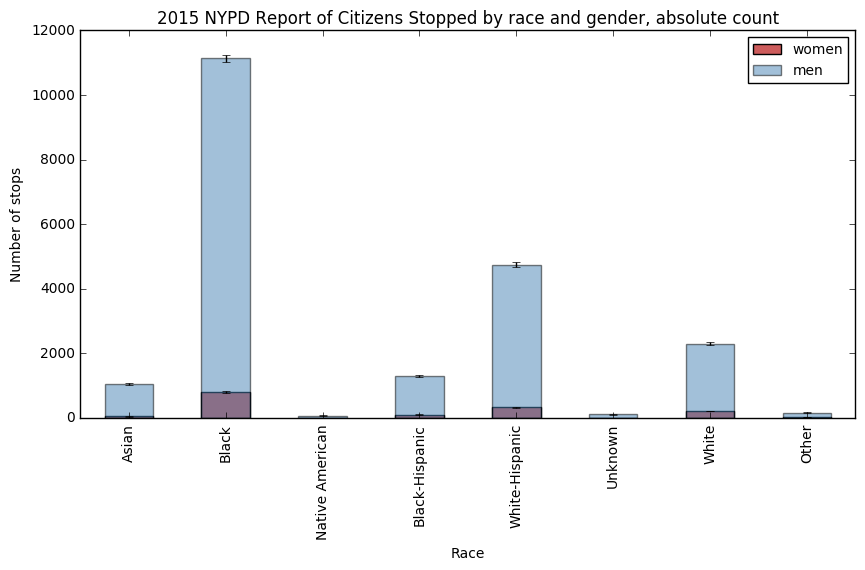

In [74]:
fig=pl.figure(figsize(10,5))

counts_w = df.race[df.sex == "F"].groupby([df.race]).count()
norm_w = 1
error_w = np.sqrt(counts_w)
ax=((counts_w) / norm_w).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_w) / norm_w, (error_w) / norm_w)], label='women stopped')

counts_m = df.race[df.sex == "M"].groupby([df.race]).count()
norm_m = 1
error_m=np.sqrt(counts_m)
((counts_m) / norm_m).plot(kind="bar", alpha=0.5, yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                           color='SteelBlue', label='men stopped')
ax.xaxis.set_ticklabels(['Asian','Black','Native American','Black-Hispanic',
                         'White-Hispanic','Unknown','White','Other'], fontsize=10)
ax.set_ylabel ("Number of stops")
ax.set_xlabel ("Race")
pl.legend(['women','men'],fontsize='medium')
pl.title('2015 NYPD Report of Citizens Stopped by race and gender, absolute count')

Figure 1: Distribution of citizens stopped by race and gender in 2015, absolute counts, with statistical errors.  This shows black and white hispanics with the highest absolute numbers.  This does not however give us the ratio counts.

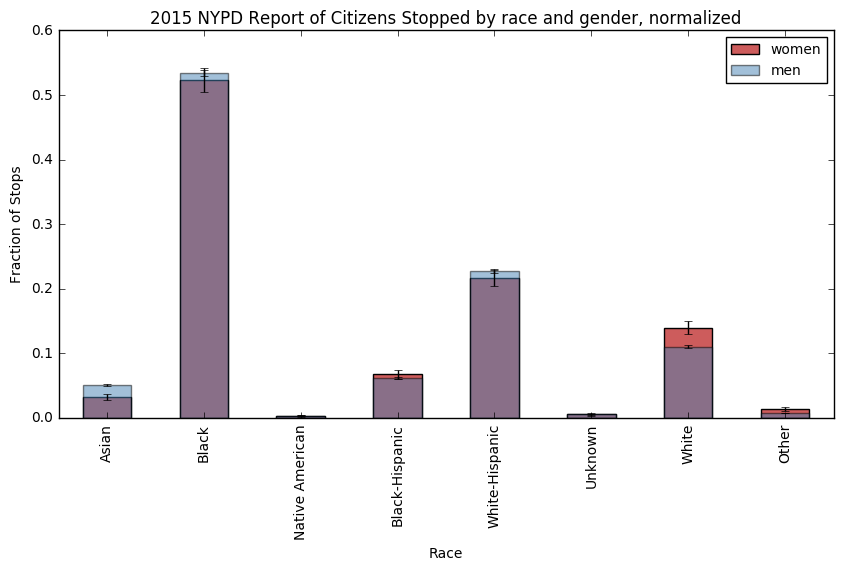

In [73]:
fig = pl.figure(figsize(10,5))

norm_w = counts_w.sum()
error_w = np.sqrt(counts_w)
((counts_w) / norm_w).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_w) / norm_w, (error_w) / norm_w)], 
                           label='women')

norm_m = counts_m.sum()
ax = ((counts_m) / norm_m).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_m) / norm_m, (error_m) / norm_m)], 
                                color='SteelBlue', label='men')

ax.xaxis.set_ticklabels(['Asian','Black','Native American','Black-Hispanic',
                         'White-Hispanic','Unknown','White','Other'], fontsize=10)
ax.set_ylabel ("Fraction of Stops")
ax.set_xlabel ("Race")
pl.legend(['women','men'],fontsize='medium')
pl.title('2015 NYPD Report of Citizens Stopped by race and gender, normalized')

Figure 2: Distribution of citizens stopped by race and gender in 2015, normalized.  The fraction of stops gives insight so that the races are comparable.